In [14]:
import os
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np

audio_fpath = "c:/Users/김영훈/Desktop"
audio_clips = os.listdir(audio_fpath)
print("No. of .wav files in audio folder = ",len(audio_clips))

No. of .wav files in audio folder =  37


In [20]:
x, sr = librosa.load('c:/Users/김영훈/Desktop/gilda.wav', sr=44100)

print(type(x), type(sr))
print(x.shape, sr)

<class 'numpy.ndarray'> <class 'int'>
(85248711,) 44100


In [21]:
X = librosa.stft(x)
Xdb_train = librosa.amplitude_to_db(abs(X))

In [22]:
Xdb_train.shape

(1025, 166502)

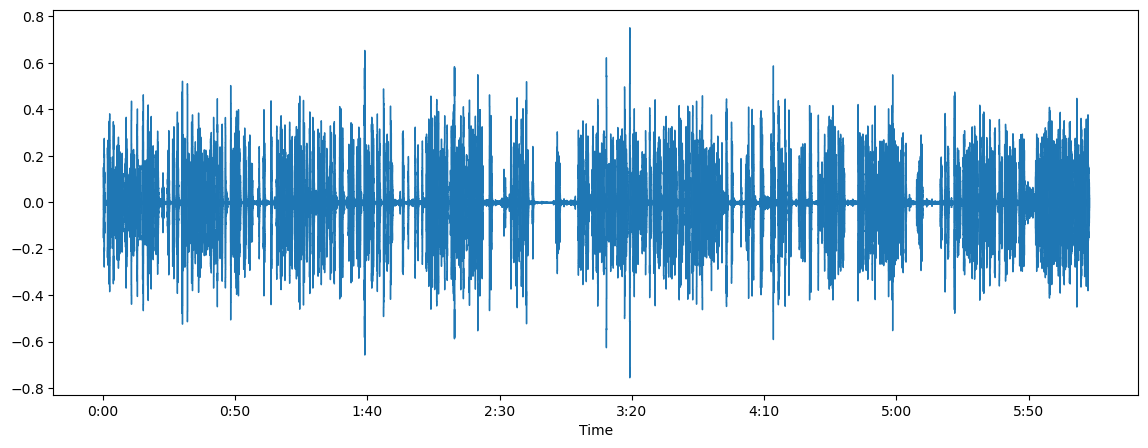

In [9]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)

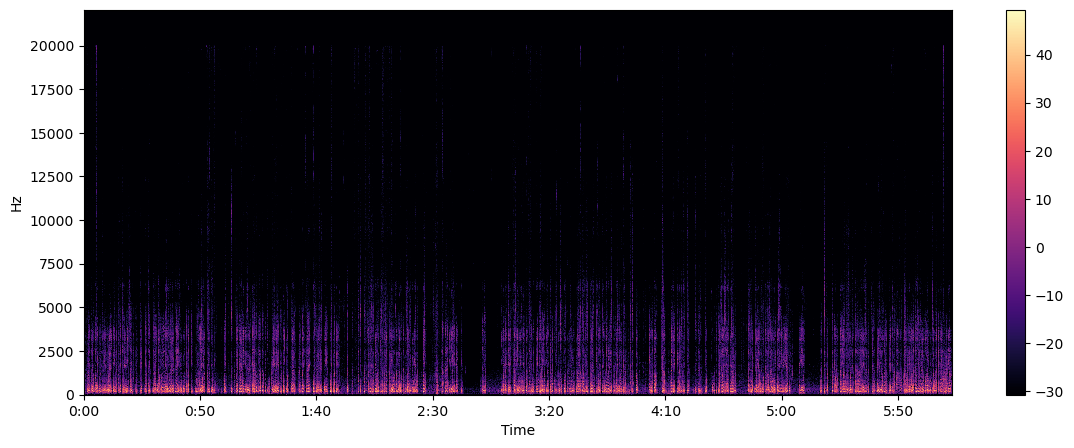

In [12]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

In [13]:
Xdb.shape

(1025, 32124)

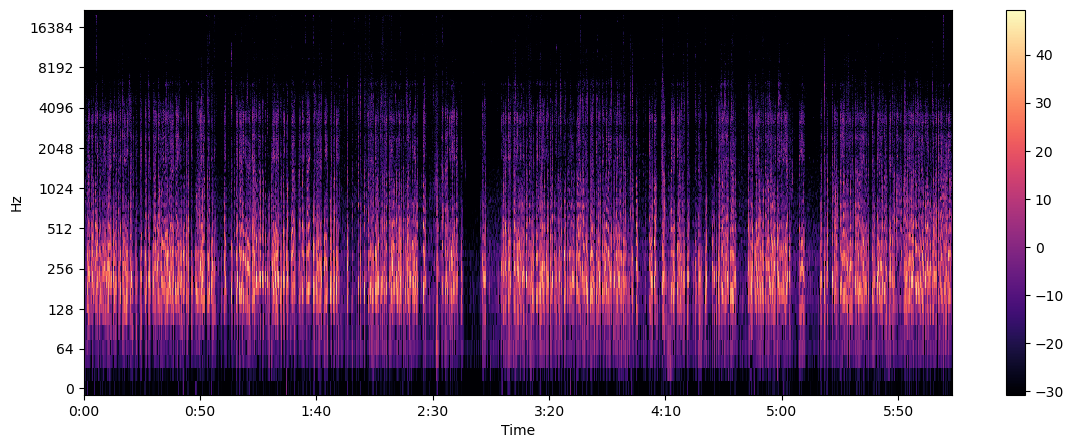

In [11]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

In [26]:
X = Xdb_train[np.newaxis, ..., np.newaxis]
print(X.shape)  # (1, 1025, 166502, 1)


(1, 1025, 166502, 1)


In [27]:
def split_spectrogram(spectrogram, window_size, step_size):
    """
    슬라이딩 윈도우 방식으로 스펙트로그램 데이터를 분할
    - spectrogram: 원본 스펙트로그램 (freq, time)
    - window_size: 분할할 창 크기 (time steps)
    - step_size: 창 이동 간격 (time steps)
    """
    freq, total_time = spectrogram.shape
    segments = []
    for start in range(0, total_time - window_size + 1, step_size):
        segment = spectrogram[:, start:start + window_size]
        segments.append(segment)
    return np.array(segments)

# 스펙트로그램 데이터 분할
window_size = 2000  # 2000 시간 스텝
step_size = 1000    # 1000 시간 스텝
X_segments = split_spectrogram(Xdb_train, window_size, step_size)

# 차원 변경: (샘플 수, 주파수, 시간) -> (샘플 수, 주파수, 시간, 채널)
X_segments = X_segments[..., np.newaxis]

print(X_segments.shape)  # 예: (164, 1025, 2000, 1)


(165, 1025, 2000, 1)


In [28]:
y = np.zeros(X_segments.shape[0])  # 예: 클래스 0


In [29]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_segments, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)  # (훈련 샘플 수, 1025, 2000, 1)
print("X_val shape:", X_val.shape)      # (검증 샘플 수, 1025, 2000, 1)
print("y_train shape:", y_train.shape)  # (훈련 샘플 수,)
print("y_val shape:", y_val.shape)      # (검증 샘플 수,)


X_train shape: (132, 1025, 2000, 1)
X_val shape: (33, 1025, 2000, 1)
y_train shape: (132,)
y_val shape: (33,)


In [30]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(1025, 2000, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')  # 클래스 개수에 맞게 출력 노드 조정
])


e:\anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [36]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Conv2DTranspose

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(1025, 2000, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2DTranspose(64, (3, 3), activation='relu'),
    Conv2DTranspose(32, (3, 3), activation='relu'),

    Conv2D(1, (3, 3), activation='linear', padding='same')  # 출력: (1025, 2000, 1)
])

model.summary()

e:\anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 1023, 1998, 32) │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 511, 999, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 511, 999, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 509, 997, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 254, 498, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 254, 498, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 256, 500, 64)   │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 258, 502, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 258, 502, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
model.compile(
    optimizer='adam',                      # Adam optimizer
    loss='mean_squared_error',             # MSE: 연속적인 스펙트로그램 값을 예측
    metrics=['mean_absolute_error']        # 추가적인 평가 지표
)

